In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
%matplotlib inline 

v1 = np.array([[0.0, 0.0,0.0,0.0],[1.0, 1.0,1.0,1.0], [1.0/2, 1.0/2,1.0/2,1.0/2], [1.0/4, 1.0/4,1.0/4,1.0/4]])
v2 = np.array([[0.0, 0.0,0.0,0.0],[1.0, 1.0,1.0,1.0]]) # good
v3 = np.array([[1.0, 1.0,0.0,1.0],[1.0, 0.0,2.0,1.0]])
v4 = np.array([[1.0,0.0,1.0],[ 0.0,2.0,1.0], [ 0.0,0.0,1.0], [ 1.0,2.0,1.0]])
v5 = np.zeros((2,4))
vn = np.array([[0.0,0.0,0.0],[1.0,1.0,0.0],[0.0,0.0,2.0],[1.0,1.0,2.0]])
v6 = np.array([[1.0,-1.0],[2.0,0.0],[3.0,1.0],[-1.0,1.0],[-2.0,0.0],[-3.0,-1.0]])

v = v6
m_ = np.mean(v,axis=0)
v = v - m_
U,S,V = np.linalg.svd(v)
epsilon = 0.000001
npoints, ndim = v.shape


In [2]:
print (v)
print (U,S,V)

[[ 1. -1.]
 [ 2.  0.]
 [ 3.  1.]
 [-1.  1.]
 [-2.  0.]
 [-3. -1.]]
[[-0.15448992  0.62673721  0.00893033  0.68481338  0.33794152 -0.00893033]
 [-0.36883324  0.17501059 -0.60007595 -0.301416    0.14932997  0.60007595]
 [-0.58317656 -0.27671604  0.65537111  0.02614958  0.18538923  0.34462889]
 [ 0.15448992 -0.62673721 -0.30181189  0.63251422 -0.03283695  0.30181189]
 [ 0.36883324 -0.17501059  0.0214085  -0.19681768  0.89088691 -0.0214085 ]
 [ 0.58317656  0.27671604  0.34462889 -0.02614958 -0.18538923  0.65537111]] [5.3524864  1.83054346] [[-0.98708746 -0.16018224]
 [ 0.16018224 -0.98708746]]


In [3]:
print (S)
if not (np.abs(S) < epsilon).any():
    dim_to_remove = S.shape[0]
else:
    dim_to_remove = np.argmax(np.abs(S) < epsilon)
print (dim_to_remove)
diag_l = S.shape[0]
reconstruct_diag = np.zeros((npoints, ndim))
reconstruct_diag[:diag_l,:diag_l] = np.diag(S)

new_pts = np.matmul(U,reconstruct_diag)
print (new_pts)
print (new_pts[:, :dim_to_remove])

[5.3524864  1.83054346]
2
[[-0.82690521  1.1472697 ]
 [-1.97417492  0.32036449]
 [-3.12144462 -0.50654073]
 [ 0.82690521 -1.1472697 ]
 [ 1.97417492 -0.32036449]
 [ 3.12144462  0.50654073]]
[[-0.82690521  1.1472697 ]
 [-1.97417492  0.32036449]
 [-3.12144462 -0.50654073]
 [ 0.82690521 -1.1472697 ]
 [ 1.97417492 -0.32036449]
 [ 3.12144462  0.50654073]]


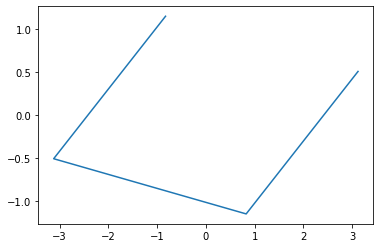

In [6]:
plt.figure()
plt.plot(new_pts[:,0],new_pts[:,1])

In [ ]:
def toHull(low_dim_pts_reduct):
    if low_dim_pts_reduct.shape[1] == 1:
        lb = np.min(low_dim_pts_reduct)
        ub = np.max(low_dim_pts_reduct)
        # x <= ub  -x >= -lb
        A = np.array([[1.0],[-1.0]])
        b = np.array([ub, -lb])
    else:
        # convex hull will get you Ax + b <= 0
        hull = ConvexHull(points=low_dim_pts_reduct)
        A = hull.equations[:,:-1]
        b = -hull.equations[:,-1]
    print (A,b)
    return A,b

In [9]:
def toBoxHull(pts):
    dim = pts.shape[1]
    lb = np.amin(pts, axis=0)
    ub = np.amax(pts, axis=0)
    retA = np.zeros((2*dim, dim))
    retb = np.zeros((2*dim))
    for idx in range(dim):
        retA[2*idx+0,idx] = 1.0
        retA[2*idx+1,idx] = -1.0
        retb[2*idx+0] = ub[idx]
        retb[2*idx+1] = -lb[idx]
    print (retA,retb)
    return retA, retb

In [10]:
toBoxHull(new_pts)

[[ 1.  0.]
 [-1.  0.]
 [ 0.  1.]
 [ 0. -1.]] [3.12144462 3.12144462 1.1472697  1.1472697 ]


(array([[ 1.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0., -1.]]), array([3.12144462, 3.12144462, 1.1472697 , 1.1472697 ]))

In [11]:
low_dim_pts_reduct = new_pts[:, :dim_to_remove]
if dim_to_remove != 0:
    A,b = toBoxHull(low_dim_pts_reduct)
    # complete to the full dimension
    n_rows = A.shape[0]
    n_cols = A.shape[1]

    num_var_to_add = ndim - (dim_to_remove)

    zero4 = np.zeros((n_rows,num_var_to_add))
    rows_to_append = np.zeros((2*num_var_to_add, n_cols+num_var_to_add))
    for idx in range(num_var_to_add):
        rows_to_append[idx*2,n_cols+ idx] = 1
        rows_to_append[idx*2+1,n_cols+ idx] = -1

    trueA = np.vstack([np.hstack([A, zero4]), rows_to_append])
    trueB = np.append(b, [0.0, 0.0]*num_var_to_add)
else:
    #num_var_to_add = ndim # v.shape[1] - (dim_to_remove)  # v.shape[1] 
    # directly construct trueA trueB
    trueA = np.zeros((ndim*2, ndim))
    for idx in range(ndim):
        trueA[idx*2,idx] = 1
        trueA[idx*2+1,idx] = -1
    trueB = np.zeros(ndim*2)

    
print (trueA)
print (trueB)

[[ 1.  0.]
 [-1.  0.]
 [ 0.  1.]
 [ 0. -1.]] [3.12144462 3.12144462 1.1472697  1.1472697 ]
[[ 1.  0.]
 [-1.  0.]
 [ 0.  1.]
 [ 0. -1.]]
[3.12144462 3.12144462 1.1472697  1.1472697 ]


In [12]:
finalA = np.matmul(trueA, V)
finalA

array([[-0.98708746, -0.16018224],
       [ 0.98708746,  0.16018224],
       [ 0.16018224, -0.98708746],
       [-0.16018224,  0.98708746]])

In [13]:
finalB = np.matmul(finalA, m_) + trueB

In [14]:
finalB

array([3.12144462, 3.12144462, 1.1472697 , 1.1472697 ])

In [18]:
c= finalB; a = finalA[:,0]; b = finalA[:,1]

In [16]:
draw_x = np.linspace(-5,5,20)

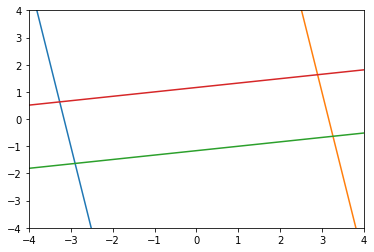

In [22]:
plt.figure()
for idx in range(4):
    a0 = a[idx]
    b0 = b[idx]
    c0 = c[idx]
    draw_y = (c0-a0*draw_x)/b0
    plt.plot(draw_x,draw_y)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()

In [ ]:
a = true